## House Price Prediction

In this project I will present my solution to the Kaggle competition: Housing Prices Competition for Kaggle Learn Users
(https://www.kaggle.com/competitions/home-data-for-ml-course/overview). Even though this competition is intended to be a learning experience rather than a challenge, it allows to apply some of the most important concepts involved in solving machine learning problems. First I will explain how I dealt with missing values emphasizing the importance of exploratory analysis in this process, then I will give a detailed explanation of how categorical features were numerically encoded. Finally, the process of training the model is explained.  Using this methodology I was able to reach the position 479 in a leaderboard consisting of about 60000 competitors. Considering the fact that no complex feature engineering was performed this is a considerable achievement. Thus the main goal of this project was not the modelling part but the preprocessing stage. 


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from scipy import stats

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Load data using Id column as index
# test.csv contains new data points with unknown target 
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

## EDA

One of the most important steps in any machine learning project is the exploratory data analysis (EDA). This stage consists in understanding the data by using simple techniques and tools such as descriptive statistics and data visualizations; the main goal here is to be able to detect features that might be relevant for the solution of the problem, summarize main characteristics of data, recognize missing values or outliers, or detect any kind of error that should be treated before trying to build a model.  

At this point is important to note that before we can work with data is mandatory to split data into a train set and a validation set to avoid data leakage. Data leakage happens when information about the thing we are trying to predict is used to build the model. This can lead to models that overfit to data but have no good predictive ability.

First we need to understand the type of variables (numerical, categorical, etc) in the dataset, and along with this step we can compute the total number of missing values for each predictor. Using this information we can decide which features need to be transformed from categorical to numerical or whether they need to be removed due to a high number of missing values. If this number is too high it might be desirable to remove them. Furthermore, imputation of missing values is not straightforward and most of the time requires the use of domain knowledge to be applied correctly. 

In [3]:
# To avoid data leakage separate data into train and validation sets
df_train = df.sample(frac=0.75, random_state=0)
indexes = df_train.index
indexes = df.index.isin(indexes)

df_val = df[~indexes]

df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1095 non-null   int64  
 1   MSSubClass     1095 non-null   int64  
 2   MSZoning       1095 non-null   object 
 3   LotFrontage    907 non-null    float64
 4   LotArea        1095 non-null   int64  
 5   Street         1095 non-null   object 
 6   Alley          75 non-null     object 
 7   LotShape       1095 non-null   object 
 8   LandContour    1095 non-null   object 
 9   Utilities      1095 non-null   object 
 10  LotConfig      1095 non-null   object 
 11  LandSlope      1095 non-null   object 
 12  Neighborhood   1095 non-null   object 
 13  Condition1     1095 non-null   object 
 14  Condition2     1095 non-null   object 
 15  BldgType       1095 non-null   object 
 16  HouseStyle     1095 non-null   object 
 17  OverallQual    1095 non-null   int64  
 18  OverallC

## Dealing with missing values 

According to this first step in the analysis there is a total of 81 features (38 numerical and 43 categorical) and many of them have missing values; however, only for some of them thses represent a significant fraction. We can plot the number of missing values for each column and decide whether we keep it or remove it. In this case I decided to remove features with a fraction of missing values higher than 0.45. The rest of the features have a lower fraction and we can impute values based on the description of each specific feature. For those features with imputed values a good trick that improves predictive power of models is to include a flag boolean variable that indicates if a value was imputed (1) or not (0). 

Let's take a look at the columns with missing values and create a dataframe containing this information.

In [5]:
# define a function that returns the number of missing values in each column for all dataframes
def missing_values_cols(dataframes, names):
    series = [df.isna().sum() for df in dataframes]
    series.append(dataframes[0].dtypes)
    missing_df = pd.DataFrame(series).T
    
    names = names
    names.append('type')
    missing_df.columns = names
    
    missing_df = missing_df[missing_df[names[:-1]].sum(axis=1) > 0]
    
    return missing_df

In [6]:
missing_df = missing_values_cols([df_train, df_val, df_test], ['train', 'validation', 'test'])
missing_df

,train,validation,test,type
MSZoning,0,0,4.0,object
LotFrontage,188,71,227.0,float64
Alley,1020,349,1352.0,object
Utilities,0,0,2.0,object
Exterior1st,0,0,1.0,object
Exterior2nd,0,0,1.0,object
MasVnrType,6,2,16.0,object
MasVnrArea,6,2,15.0,float64
BsmtQual,28,9,44.0,object
BsmtCond,28,9,45.0,object


Imputation of the validation and test sets must be done using the train set. First let's consider numeric features. 

In [7]:
missing_df[missing_df['type']!='object']

,train,validation,test,type
LotFrontage,188,71,227.0,float64
MasVnrArea,6,2,15.0,float64
BsmtFinSF1,0,0,1.0,int64
BsmtFinSF2,0,0,1.0,int64
BsmtUnfSF,0,0,1.0,int64
TotalBsmtSF,0,0,1.0,int64
BsmtFullBath,0,0,2.0,int64
BsmtHalfBath,0,0,2.0,int64
GarageYrBlt,64,17,78.0,float64
GarageCars,0,0,1.0,int64


In [8]:
# Add a flag column indicating whether a value was imputed or not (only for columns
# with a large number of missing values)
df_train['FlagLotFrontage'] = df_train['LotFrontage'].isna().astype(int)
df_train['FlagMasVnrArea'] =  df_train['MasVnrArea'].isna().astype(int)
df_train['FlagGarageYrBlt'] =  df_train['GarageYrBlt'].isna().astype(int)

df_val['FlagLotFrontage'] = df_val['LotFrontage'].isna().astype(int)
df_val['FlagMasVnrArea'] =  df_val['MasVnrArea'].isna().astype(int)
df_val['FlagGarageYrBlt'] =  df_val['GarageYrBlt'].isna().astype(int)

df_test['FlagLotFrontage'] = df_test['LotFrontage'].isna().astype(int)
df_test['FlagMasVnrArea'] =  df_test['MasVnrArea'].isna().astype(int)
df_test['FlagGarageYrBlt'] =  df_test['GarageYrBlt'].isna().astype(int)

In this case we can use the description of the data to perform imputation of missing values 

In [9]:
# Impute missing values assuming that NaN values mean 0 Lot frontage, 0 MasVnrArea and very old garage
df_train['LotFrontage'].fillna(0, inplace=True)
df_train['MasVnrArea'].fillna(0, inplace=True)
df_train['GarageYrBlt'].fillna(df_train['GarageYrBlt'].min(), inplace=True)

df_val['LotFrontage'].fillna(0, inplace=True)
df_val['MasVnrArea'].fillna(0, inplace=True)
df_val['GarageYrBlt'].fillna(df_train['GarageYrBlt'].min(), inplace=True)

df_test['LotFrontage'].fillna(0, inplace=True)
df_test['MasVnrArea'].fillna(0, inplace=True)
df_test['GarageYrBlt'].fillna(df_train['GarageYrBlt'].min(), inplace=True)

In [10]:
# For columns with missing values only in the test set we can just simply drop the corresponding rows or look at
# the data description and guess plausible values. I will follow this second option and impute values 
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 
            'BsmtHalfBath', 'GarageCars', 'GarageArea']:
    df_test[col].fillna(0, inplace=True)

In [11]:
# No missing values remaining
missing_df = missing_values_cols([df_train, df_val, df_test], ['train', 'validation', 'test'])
missing_df[missing_df['type']!='object']

,train,validation,test,type


Let's now take a look at categorical features

In [12]:
# Tranform MSSubclass variable into a categorical 
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
df_val['MSSubClass'] = df_val['MSSubClass'].apply(str)

df_test['MSSubClass'] = df_test['MSSubClass'].apply(str)

In [13]:
# No more numerical features with missing values
missing_df = missing_values_cols([df_train, df_val, df_test], ['train', 'validation', 'test'])
missing_df

,train,validation,test,type
MSZoning,0,0,4.0,object
Alley,1020,349,1352.0,object
Utilities,0,0,2.0,object
Exterior1st,0,0,1.0,object
Exterior2nd,0,0,1.0,object
MasVnrType,6,2,16.0,object
BsmtQual,28,9,44.0,object
BsmtCond,28,9,45.0,object
BsmtExposure,29,9,44.0,object
BsmtFinType1,28,9,42.0,object


Note that there are some categorical features with a high number of missing values. I will drop columns with a fraction of missing values larger than a threshold value.

In [14]:
# Remove columns having many missing values > 0.5
# Function that plots features with a fraction of missing values larger than "thresh"
def plot_cols_high_missing(df, thresh=0.5, figsize=(9,7)):
    try:
        cols_na = df.isna().sum() 
        cols_missing = (cols_na / len(df)) > thresh

        data = cols_na[cols_missing]

        fig, ax = plt.subplots(1, 1, figsize=figsize) 

        ax = sns.barplot(x=data.index, y=data.values, ax=ax)

        ax.axhline(len(df), linestyle='--', color='k')
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 60)

        ax.set_ylabel('# Missing values')
        return ax, list(data.index)
    
    except:
        print('No columns with missing values')

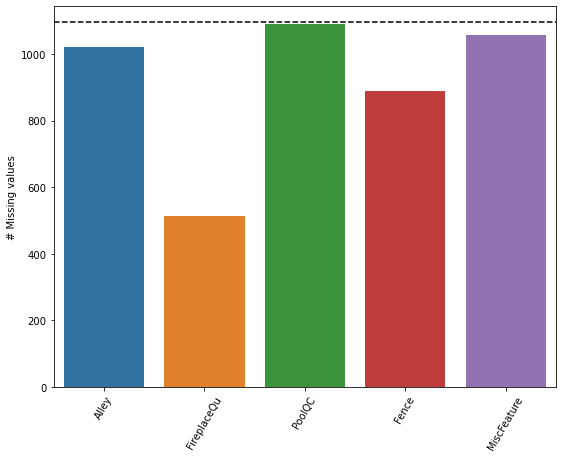

In [16]:
ax = plot_cols_high_missing(df_train, thresh=0.45)
plt.savefig("high_missing.png", dpi=150)

In [17]:
df_train.drop(labels=['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)
df_val.drop(labels=['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)
df_test.drop(labels=['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

In [18]:
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [19]:
# No more numerical features with missing values
missing_df = missing_values_cols([df_train, df_val, df_test], ['train', 'validation', 'test'])
missing_df

,train,validation,test,type
MSZoning,0,0,4.0,object
Utilities,0,0,2.0,object
Exterior1st,0,0,1.0,object
Exterior2nd,0,0,1.0,object
MasVnrType,6,2,16.0,object
BsmtQual,28,9,44.0,object
BsmtCond,28,9,45.0,object
BsmtExposure,29,9,44.0,object
BsmtFinType1,28,9,42.0,object
BsmtFinType2,29,9,42.0,object


In [20]:
missing_df.sum(axis=0)

/tmp/ipykernel_8185/30144209.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  missing_df.sum(axis=0)


train           405
validation      115
test          555.0
dtype: object

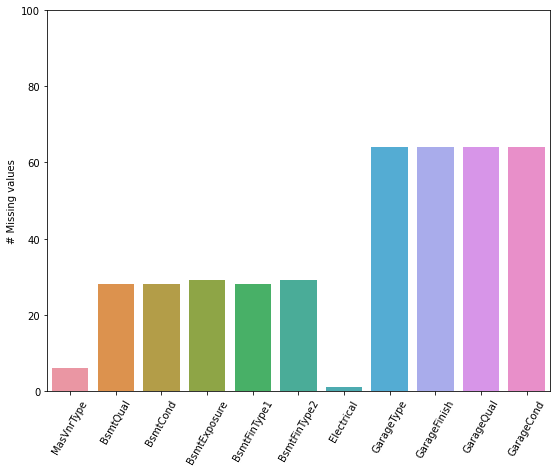

In [22]:
ax, cols = plot_cols_high_missing(df_train, thresh=0)
ax.set_ylim(0,100)

plt.savefig("low_missing.png", dpi=150)

By looking at data description I notice that NaN values for Bsmt or Garage features represent no garage. Therefore I will impute missing values with NA and add a flag variable for each feature

In [23]:
# First I add a flag variables, for this I now create a function:
def add_flag(dataframes, cols):
    for col in cols:
        name = 'Flag'+ col
        for df in dataframes:
            df[name] = df[col].isna().astype(int)
            
def impute(dataframes, cols, val):
    for col in cols:
        for df in dataframes:
            df[col].fillna(val, inplace=True)

In [24]:
missing_df.index

Index(['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'SaleType'],
      dtype='object')

In [25]:
cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
add_flag([df_train, df_val, df_test], cols=cols)
impute([df_train, df_val, df_test], cols=cols, val='NA')

In [26]:
add_flag([df_train, df_val, df_test], cols=['MasVnrType'])
impute([df_train, df_val, df_test], cols=['MasVnrType'], val='None')

In [27]:
# WE still have columns with missing values 
missing_df = missing_values_cols([df_train, df_val, df_test], ['train', 'validation', 'test'])
missing_df

,train,validation,test,type
MSZoning,0,0,4.0,object
Utilities,0,0,2.0,object
Exterior1st,0,0,1.0,object
Exterior2nd,0,0,1.0,object
Electrical,1,0,0.0,object
KitchenQual,0,0,1.0,object
Functional,0,0,2.0,object
SaleType,0,0,1.0,object


In [28]:
df_train.fillna(value='NA', inplace=True)
df_test.fillna(value='NA', inplace=True)

In [29]:
#df_train.reset_index(inplace=True, drop=True)
#df_test.reset_index(inplace=True, drop=True)

In [30]:
# No more missing values
missing_df = missing_values_cols([df_train, df_val, df_test], ['train', 'validation', 'test'])
missing_df

,train,validation,test,type


In [31]:
df_train.replace('NA', 'NO_AV', inplace=True)
df_val.replace('NA', 'NO_AV', inplace=True)
df_test.replace('NA', 'NO_AV', inplace=True)

### Convert categorical into numerical
The next step consists in transforming categorical features into numerical features. Depending on the cardinality of the corresponding categorical feature a different encoding technique is used.

Encoding categorical features as numerical is necessary since most machine learning algorithms can only operate with numerical data. Depending on the type of categorical feature we must employ a different encoding technique; for example, one-hot encoding is better suited for low cardinality features while target encoding is a better alternative for high-cardinality features. In this project I considered three different encoding techniques: ordinal encoding, for categorical features that have an intrinsic order; target encoding, for high cardinality features (n >= 15); and one-hot encoding for the rest of features. With all this techniques we must use the training dataset to encode features both in the validation set and test set. The reason for this is that, in principle, both the validation and test set represent future data points that are not known at the moment we are training the model. Of these three methods only target encoding is difficult to understand for reasons I will explain in a moment. 

In [32]:
# Create a list that stores the features that have been transformed using any encoding technique.
transformed_features = []

In [33]:
# Lets look at the cardinality of each categorical feature
df_train.select_dtypes(include='object').nunique()

MSSubClass       15
MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     24
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          7
Exterior1st      15
Exterior2nd      15
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          5
BsmtCond          5
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           5
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

One-hot encoding is usually not appropriate for high cardinality categorical features. In some cases the categorical features have an inherent order, in which case, we can use ordinal encoding. By inspecting the data description file we find out that there are 14 features that can be encoded this way. 

In [34]:
df_test['BsmtFinType1'].unique()

array(['Rec', 'ALQ', 'GLQ', 'Unf', 'BLQ', 'LwQ', 'NO_AV'], dtype=object)

In [35]:
from sklearn.preprocessing import OrdinalEncoder

# Function that performs ordinal encoding. Users must provide the correct order in the "categories" prameter 
def ordinal_encoding(categories, col, dataframe):
    encoder = OrdinalEncoder(categories=[categories], handle_unknown='use_encoded_value', unknown_value=np.nan)
    col_encoded = encoder.fit_transform(dataframe[col].values.reshape(-1, 1))
    
    return col_encoded

def ordinal_encode_cols(categories, cols, dataframes, drop=False):
    for df in dataframes:
        for col in cols:
            col_encoded = ordinal_encoding(categories, col, df)
            new_name = 'enc_' + col
            df[new_name] = col_encoded
        if drop:
            df.drop(cols, axis=1, inplace=True)

In [36]:
categories = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
ordinal_encode_cols(categories, ['ExterQual', 'ExterCond'], [df_train, df_val, df_test])

In [37]:
categories = ['NO_AV', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
ordinal_encode_cols(categories, ['BsmtQual', 'BsmtCond'], [df_train, df_val, df_test])

In [38]:
categories = ['NO_AV', 'No', 'Mn', 'Av', 'Gd']
ordinal_encode_cols(categories, ['BsmtExposure'], [df_train, df_val, df_test], drop=False)

In [39]:
categories = ['NO_AV', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
ordinal_encode_cols(categories, ['BsmtFinType1', 'BsmtFinType2'], [df_train, df_val, df_test], drop=False)

In [40]:
categories = ['NO_AV', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
ordinal_encode_cols(categories, ['HeatingQC', 'KitchenQual','GarageQual', 'GarageCond'], 
                    [df_train, df_val, df_test])

In [41]:
transformed_features.extend(['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                             'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
                             'GarageQual', 'GarageCond'])

We still have some categorical features to transform. Now we use Target encoding to transform features with high cardinality. Applying target encoding is a tricky business since there is a high risk that information from the target leaks into the encoded feature. If this happens it can lead to overfitting and a poor generalization ability. Therefore when performing target encoding we need to be careful that information we are not supposed to know leaks into the training set. This means that target encoding of the validation and test set must be done using **only** the training data. For the encoding of features in the training set we must perform cross validation or nested-cross validation. 

In [42]:
cols = df_train.select_dtypes(include='object').nunique().index
df_train.select_dtypes(include='object').nunique()[~cols.isin(transformed_features)]

MSSubClass       15
MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     24
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          7
Exterior1st      15
Exterior2nd      15
MasVnrType        4
Foundation        6
Heating           5
CentralAir        2
Electrical        5
Functional        7
GarageType        7
GarageFinish      4
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

In [43]:
from sklearn.model_selection import KFold

In [44]:
# define a function to apply target encoding using cross-validation

def target_encode_test(df_train, df_test, col, target):
    dt = df_train.groupby(col)[target].agg(['mean']).reset_index(drop=False)
    tmp = df_test.merge(dt, on=col, how='left')['mean'].values
    #fill_na(df_test, col)
    return tmp

def target_encode_train(df_train, col, target, n_splits=5):
    kf = KFold(n_splits = n_splits, shuffle=False)
    
    folds = []
    for result in kf.split(df_train):
        dt = df_train.iloc[result[0]].groupby(col)[target].agg(['mean']).reset_index(drop=False)
        tmp = df_train.iloc[result[1]].merge(dt, on=col, how='left')[[col,'mean']]
        folds.append(tmp)
        
    return pd.concat([*folds]).reset_index(drop=True)


def target_encode_nested(df_train, col, target, n_splits_out, n_splits_in):
    kf = KFold(n_splits = n_splits_out, shuffle=False)
    
    folds = []
    for result in kf.split(df_train):
        fold = target_encode_train(df_train.iloc[result[0]], col, target, n_splits_in)
        dt = fold.groupby(col).mean().reset_index(drop=False)
        tmp = df_train.iloc[result[1]].merge(dt, on=col, how='left')[[col,'mean']]
        folds.append(tmp)
        
    return pd.concat([*folds]).reset_index(drop=True)


def fill_na(df_train, col):
    pass

def target_encode_cols(df_train, cols, target, n_splits=5, nested_cv=False, nested_splits=None, drop=False):
    if nested_cv:
        for col in cols:
            new_name = 'target_enc_' + col
            df_train[new_name] = target_encode_nested(df_train, col, target, nested_splits)['mean']
            fill_na(df_train, new_name)
    else:
        for col in cols:
            new_name = 'target_enc_' + col
            df_train[new_name] = target_encode_train(df_train, col, target, n_splits)['mean']
            fill_na(df_train, new_name)
    
    if drop:
        df.drop(cols, axis=1, inplace=True)

Let's test target encoding using simple cross-validation and nested cross-validation and computing the correlation 
coefficient

In [45]:
folds = target_encode_train(df_train, col='Neighborhood', target='SalePrice', n_splits=10)

In [46]:
np.corrcoef(folds['mean'], df_train['SalePrice'])[0,1]

0.7325917133314693

In [47]:
folds = target_encode_nested(df_train, col='Neighborhood', target='SalePrice', n_splits_out=10, n_splits_in=9)

In [48]:
np.corrcoef(folds['mean'], df_train['SalePrice'])[0,1]

0.7317829469731094

It seems that Neighborhood, MSSubClass, Exterior1st and Exterior2nd are good candidates to apply target encoding. We can check this by creating box plots:

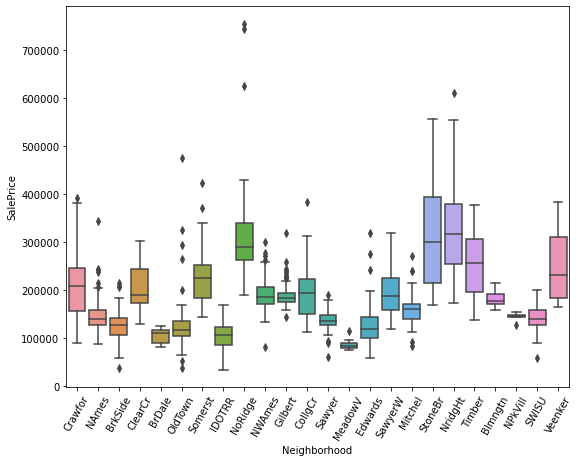

In [50]:
fig, ax = plt.subplots(1,1, figsize=(9,7))
ax = sns.boxplot(x = 'Neighborhood', y='SalePrice', data=df_train)

ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

plt.savefig("neighborhoods.png", dpi=150)
plt.show()

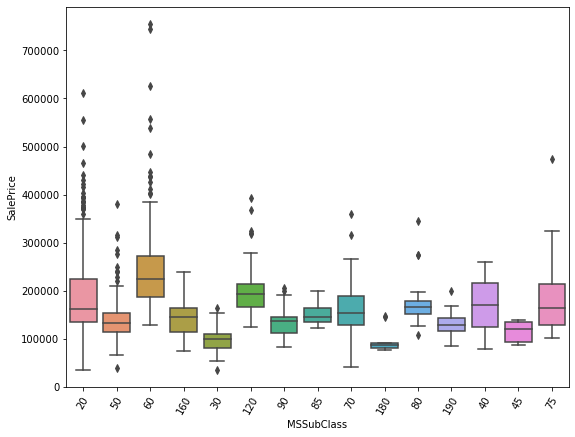

In [51]:
fig, ax = plt.subplots(1,1, figsize=(9,7))
ax = sns.boxplot(x = 'MSSubClass', y='SalePrice', data=df_train)

ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

plt.savefig("subclass.png", dpi=150)
plt.show()

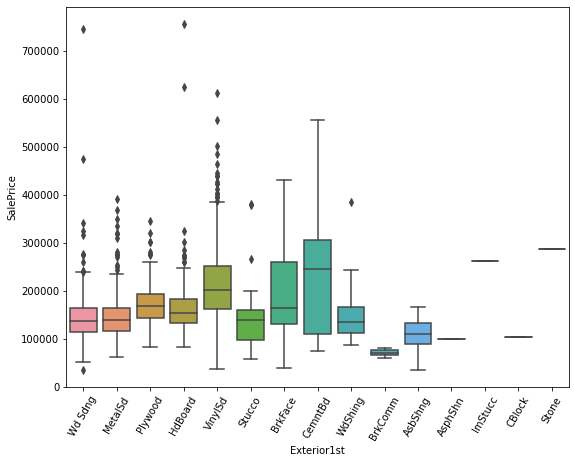

In [56]:
fig, ax = plt.subplots(1,1, figsize=(9,7))
ax = sns.boxplot(x = 'Exterior1st', y='SalePrice', data=df_train)

ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

plt.show()

In [57]:
# Apply target encoding 
df_train['target_enc_neighborhood'] = target_encode_nested(df_train, col='Neighborhood', target='SalePrice', 
                                              n_splits_out=10, n_splits_in=9)['mean']
df_train['target_enc_MSSubClass'] = target_encode_nested(df_train, col='MSSubClass', target='SalePrice', 
                                              n_splits_out=10, n_splits_in=9)['mean']
df_train['target_enc_Exterior1st'] = target_encode_nested(df_train, col='Exterior1st', target='SalePrice', 
                                              n_splits_out=10, n_splits_in=9)['mean']
df_train['target_enc_Exterior2nd'] = target_encode_nested(df_train, col='Exterior2nd', target='SalePrice', 
                                              n_splits_out=10, n_splits_in=9)['mean']

In [58]:
# Do the same for the validation and test set, note that test and val do not require cross validation
df_val['target_enc_neighborhood'] = target_encode_test(df_train, df_val, 'Neighborhood', 'SalePrice')
df_val['target_enc_MSSubClass'] = target_encode_test(df_train, df_val, 'MSSubClass', 'SalePrice')
df_val['target_enc_Exterior1st'] = target_encode_test(df_train, df_val, 'Exterior1st', 'SalePrice')
df_val['target_enc_Exterior2nd'] = target_encode_test(df_train, df_val, 'Exterior2nd', 'SalePrice')

df_test['target_enc_neighborhood'] = target_encode_test(df_train, df_test, 'Neighborhood', 'SalePrice')
df_test['target_enc_MSSubClass'] = target_encode_test(df_train, df_test, 'MSSubClass', 'SalePrice')
df_test['target_enc_Exterior1st'] = target_encode_test(df_train, df_test, 'Exterior1st', 'SalePrice')
df_test['target_enc_Exterior2nd'] = target_encode_test(df_train, df_test, 'Exterior2nd', 'SalePrice')

Now we need to check for NaN values in any of these newly created features. Categories with missing values are filled with the overall average. 

In [59]:
cols = ['target_enc_neighborhood', 'target_enc_MSSubClass', 'target_enc_Exterior1st', 'target_enc_Exterior2nd']
for col in cols:
    print('Missing values in', col, ': ', df_train[col].isna().sum())

Missing values in target_enc_neighborhood :  0
Missing values in target_enc_MSSubClass :  2
Missing values in target_enc_Exterior1st :  6
Missing values in target_enc_Exterior2nd :  4


In [60]:
cols = ['target_enc_neighborhood', 'target_enc_MSSubClass', 'target_enc_Exterior1st', 'target_enc_Exterior2nd']
for col in cols:
    print('Missing values in', col, ': ', df_val[col].isna().sum())

Missing values in target_enc_neighborhood :  2
Missing values in target_enc_MSSubClass :  0
Missing values in target_enc_Exterior1st :  0
Missing values in target_enc_Exterior2nd :  1


In [61]:
cols = ['target_enc_neighborhood', 'target_enc_MSSubClass', 'target_enc_Exterior1st', 'target_enc_Exterior2nd']
for col in cols:
    print('Missing values in', col, ': ', df_test[col].isna().sum())

Missing values in target_enc_neighborhood :  8
Missing values in target_enc_MSSubClass :  1
Missing values in target_enc_Exterior1st :  1
Missing values in target_enc_Exterior2nd :  1


In [62]:
overall_avg = df_train['SalePrice'].mean()
overall_avg

183189.66849315068

In [63]:
for col in cols:
    df_train[col].fillna(overall_avg, inplace=True)
    df_val[col].fillna(overall_avg, inplace=True)
    df_test[col].fillna(overall_avg, inplace=True)

In [64]:
transformed_features.extend(['Neighborhood', 'MSSubClass', 'Exterior1st', 'Exterior2nd'])

In [65]:
transformed_features

['ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'KitchenQual',
 'GarageQual',
 'GarageCond',
 'Neighborhood',
 'MSSubClass',
 'Exterior1st',
 'Exterior2nd']

To encode the rest of the columns I will use one-hot-encoding. This technique is better suited for low cardinality features since it create m - 1 new columns for a feature with cardinality m.

In [67]:
cols = df_train.select_dtypes(include='object').nunique().index
ohe_columns = df_train.select_dtypes(include='object').nunique()[~cols.isin(transformed_features)]
ohe_columns

MSZoning         5
Street           2
LotShape         4
LandContour      4
Utilities        2
LotConfig        5
LandSlope        3
Condition1       9
Condition2       8
BldgType         5
HouseStyle       8
RoofStyle        6
RoofMatl         7
MasVnrType       4
Foundation       6
Heating          5
CentralAir       2
Electrical       5
Functional       7
GarageType       7
GarageFinish     4
PavedDrive       3
SaleType         9
SaleCondition    6
dtype: int64

In [68]:
from sklearn.preprocessing import OneHotEncoder

In [69]:
enc = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [70]:
X_train= enc.fit_transform(df_train[ohe_columns.index])

In [71]:
X_val= enc.transform(df_val[ohe_columns.index])
X_test = enc.transform(df_test[ohe_columns.index])

/home/betor94/anaconda3/envs/DS/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [12, 15, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/betor94/anaconda3/envs/DS/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 4, 18, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [72]:
X_train_df = pd.DataFrame(X_train, columns=enc.get_feature_names_out())
X_val_df = pd.DataFrame(X_val, columns=enc.get_feature_names_out())
X_test_df = pd.DataFrame(X_test, columns=enc.get_feature_names_out())

In [73]:
df_train_enc = pd.concat([df_train, X_train_df], axis=1)
df_val_enc = pd.concat([df_val, X_val_df], axis=1)
df_test_enc = pd.concat([df_test, X_test_df], axis=1)

In [74]:
missing_df = missing_values_cols([df_train_enc, df_val_enc, df_test_enc], ['train', 'validation', 'test'])
missing_df

,train,validation,test,type


In [81]:
df_train_enc.to_csv('train_end.csv', index=False)
df_val_enc.to_csv('val_end.csv', index=False)
df_test_enc.to_csv('test_end.csv', index=False)